# Purpose
To wrangle and label the 48h observation windows for the positive class.

In [1]:
import pandas as pd
pos_lab = pd.read_csv('../data/intermediate/positive_lab_data.csv', header=None, low_memory=False)

In [2]:
columns = ['patientunitstayid', 'labname', 'labresult', 'labresultoffset', 'akidetection', 'age', 'gender', \
           'ethnicity', 'patienthealthsystemstayid', 'hospitaladmitoffset', 'unitdischargeoffset']
pos_lab.columns=columns

In [3]:
# pivot the table to get lab measurements as columns
pos_lab = pd.pivot_table(pos_lab, values=['labresult'], \
               index=['patientunitstayid', 'labresultoffset', 'akidetection', 'age', 'gender', 'ethnicity', \
                      'patienthealthsystemstayid', 'hospitaladmitoffset', 'unitdischargeoffset'], \
               columns=['labname'], aggfunc='first')
pos_lab.columns = pos_lab.columns.droplevel() # reshape column level

In [4]:
pos_lab.columns = ['BUN', 'Hct', 'Hgb', 'RBC', 'WBC x 1000', 'bedside glucose',
       'bicarbonate', 'calcium', 'chloride', 'creatinine', 'glucose',
       'platelets x 1000', 'potassium', 'sodium']

In [5]:
pd.option_context("mode.chained_assignment", None)
pos_lab.reset_index(inplace=True)
pos_lab['time_to_detect'] = pos_lab['akidetection'] - pos_lab['labresultoffset']
pos_lab = pos_lab[pos_lab['time_to_detect']/60>=12] # remove observations < 12 h from first detection
pos_lab.loc[pos_lab['time_to_detect']/60<=24, 'positive_window'] = 1 # label observation right before aki detection

In [6]:
# Next, look at empty values in each row and column
null_rows = pos_lab[['BUN', 'Hct', 'Hgb', 'RBC', 'WBC x 1000', 'bedside glucose',
       'bicarbonate', 'calcium', 'chloride', 'creatinine', 'glucose',
       'platelets x 1000', 'potassium', 'sodium']].isna().sum(axis=0)

In [7]:
null_rows

BUN                 335103
Hct                 328274
Hgb                 326421
RBC                 345765
WBC x 1000          345687
bedside glucose     177673
bicarbonate         341944
calcium             339621
chloride            332361
creatinine          334260
glucose             327535
platelets x 1000    344499
potassium           308222
sodium              318371
dtype: int64

In [8]:
# creatinine and BUN - blood urea nitrogen are important biomarkers so there cannot be empty values and no imputation
# method will be meaningful. Drop the rows with null creatinine and BUN values
pos_lab = pos_lab[~((pos_lab['creatinine'].isna()) | (pos_lab['BUN'].isna()))]
print(len(pos_lab))
null_rows = pos_lab[['BUN', 'Hct', 'Hgb', 'RBC', 'WBC x 1000', 'bedside glucose',
       'bicarbonate', 'calcium', 'chloride', 'creatinine', 'glucose',
       'platelets x 1000', 'potassium', 'sodium']].isna().sum(axis=0)
null_rows

118642


BUN                      0
Hct                  29692
Hgb                  29768
RBC                  31370
WBC x 1000           31259
bedside glucose     117546
bicarbonate           8525
calcium               5405
chloride               212
creatinine               0
glucose               1306
platelets x 1000     31842
potassium              501
sodium                 204
dtype: int64

In [9]:
# Nearly all 'bedside glucose' and 1/3 - 1/4 of 'Hct', 'Hgb', 'RBC', 'WBC x 1000', 'platelets x 1000' is missing. This 
# is too much to impute. For the rest, first impute the first available last value, if none then next value
pos_lab.drop(columns=['Hct', 'Hgb', 'RBC', 'WBC x 1000', 'bedside glucose', 'platelets x 1000'], inplace=True)

pos_lab[['bicarbonate', 'calcium', 'chloride', 'glucose','potassium', 'sodium']] = \
pos_lab.groupby('patientunitstayid')[['bicarbonate', 'calcium', 'chloride', 'glucose','potassium', \
                                      'sodium']].fillna(method='ffill').fillna(method='bfill')
null_rows = pos_lab[['BUN', 'bicarbonate', 'calcium', 'chloride', 'creatinine', 'glucose','potassium', 'sodium']].isna().sum(axis=0)
null_rows

BUN            0
bicarbonate    0
calcium        0
chloride       0
creatinine     0
glucose        0
potassium      0
sodium         0
dtype: int64

In [10]:
pos_lab.positive_window.fillna(0, inplace=True)

In [12]:
pos_lab.sort_values(by=['patientunitstayid', 'labresultoffset'], ascending=True, inplace=True)

In [13]:
import sys, os
sys.path.insert(0, os.path.abspath('../src/'))
import lab_wrangling

In [15]:
import time
start_time = time.time()
columns = ['BUN', 'bicarbonate', 'calcium', 'chloride', 'creatinine', 'glucose','potassium', 'sodium']
funcs = ['min', 'mean', 'max', 'var']
df = pos_lab
pos_lab = lab_wrangling.calc_stats_windows(df, columns, funcs)
print(time.time() - start_time)

725.5301370620728


In [36]:
print(len(pos_lab))
pos_lab.dropna(inplace=True)
print(len(pos_lab))

118642
86552


In [39]:
pos_lab.positive_window.sum()

11752.0

In [40]:
11752/86552

0.13577964691746003

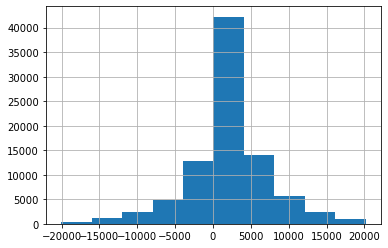

In [41]:
pos_lab['labresultoffset'].hist()

In [43]:
pos_lab.reset_index().columns

Index(['patientunitstayid', 'time_to_detect', 'labresultoffset',
       'akidetection', 'age', 'gender', 'ethnicity',
       'patienthealthsystemstayid', 'hospitaladmitoffset',
       'unitdischargeoffset', 'BUN', 'bicarbonate', 'calcium', 'chloride',
       'creatinine', 'glucose', 'potassium', 'sodium', 'positive_window',
       'BUN_min', 'BUN_mean', 'BUN_max', 'BUN_var', 'bicarbonate_min',
       'bicarbonate_mean', 'bicarbonate_max', 'bicarbonate_var', 'calcium_min',
       'calcium_mean', 'calcium_max', 'calcium_var', 'chloride_min',
       'chloride_mean', 'chloride_max', 'chloride_var', 'creatinine_min',
       'creatinine_mean', 'creatinine_max', 'creatinine_var', 'glucose_min',
       'glucose_mean', 'glucose_max', 'glucose_var', 'potassium_min',
       'potassium_mean', 'potassium_max', 'potassium_var', 'sodium_min',
       'sodium_mean', 'sodium_max', 'sodium_var'],
      dtype='object')

In [44]:
pos_lab.to_csv('../data/final/positive_class_lab_wrangled.csv')

In [4]:
import pandas as pd
pos_lab = pd.read_csv('../data/final/positive_class_lab_wrangled.csv')
print(len(pos_lab.patientunitstayid.value_counts()))

20941
